In [11]:
!pip uninstall tensorflow protobuf
!pip install tensorflow protobuf==3.20.*


Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Would remove:
    /workspace/newenv/bin/estimator_ckpt_converter
    /workspace/newenv/bin/import_pb_to_tensorboard
    /workspace/newenv/bin/saved_model_cli
    /workspace/newenv/bin/tensorboard
    /workspace/newenv/bin/tf_upgrade_v2
    /workspace/newenv/bin/tflite_convert
    /workspace/newenv/bin/toco
    /workspace/newenv/bin/toco_from_protos
    /workspace/newenv/lib/python3.10/site-packages/tensorflow-2.10.0.dist-info/*
    /workspace/newenv/lib/python3.10/site-packages/tensorflow/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [10]:
import os
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define base directory for contactless fingerprints
contactless_dir = r"fingerdatset"

# Collect all contactless fingerprint images
contactless_pairs = []
all_contactless_images = []  # Store all contactless images for mismatched pairing

for i in range(1, 301):
    folder_path = os.path.join(contactless_dir, f"p{i}")
    if not os.path.exists(folder_path):
        continue

    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(".bmp")]
    
    all_contactless_images.extend(images)

    # Create matched pairs within the same person
    for j in range(len(images)):
        for k in range(j + 1, len(images)):  # Ensure different images of the same person
            contactless_pairs.append((images[j], images[k], 1))

# Creating unmatched pairs
unmatched_pairs = []
while len(unmatched_pairs) < len(contactless_pairs):
    img1, img2 = random.sample(all_contactless_images, 2)

    # Ensure it's a mismatch (from different folders)
    if os.path.dirname(img1) != os.path.dirname(img2):
        unmatched_pairs.append((img1, img2, 0))

# Combine matched and unmatched pairs
all_pairs = contactless_pairs + unmatched_pairs
random.shuffle(all_pairs)

# Convert file paths to grayscale OpenCV images (NumPy arrays)
X_left, X_right, y = [], [], []

for img1_path, img2_path, label in all_pairs:
    try:
        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

        if img1 is None or img2 is None:
            print(f"Error loading images: {img1_path}, {img2_path}")
            continue

        # Resize to fixed shape (90x90)
        img1 = cv2.resize(img1, (90, 90))
        img2 = cv2.resize(img2, (90, 90))

        # Normalize to range [0,1]
        img1 = img1.astype(np.float32) / 255.0
        img2 = img2.astype(np.float32) / 255.0

        # Expand dimensions for CNN compatibility (N, 90, 90, 1)
        img1 = np.expand_dims(img1, axis=-1)
        img2 = np.expand_dims(img2, axis=-1)

        X_left.append(img1)
        X_right.append(img2)
        y.append(label)
    except Exception as e:
        print(f"Error processing images: {img1_path}, {img2_path} - {e}")

X_left = np.array(X_left)
X_right = np.array(X_right)
y = np.array(y)

# Splitting data into train, val, test
X_train_left, X_test_left, X_train_right, X_test_right, y_train, y_test = train_test_split(
    X_left, X_right, y, test_size=0.1, random_state=42
)
X_train_left, X_val_left, X_train_right, X_val_right, y_train, y_val = train_test_split(
    X_train_left, X_train_right, y_train, test_size=0.1, random_state=42
)

# Save numpy arrays
np.save('X_train_left.npy', X_train_left)
np.save('X_train_right.npy', X_train_right)
np.save('y_train.npy', y_train)

np.save('X_val_left.npy', X_val_left)
np.save('X_val_right.npy', X_val_right)
np.save('y_val.npy', y_val)

np.save('X_test_left.npy', X_test_left)
np.save('X_test_right.npy', X_test_right)
np.save('y_test.npy', y_test)

# Print statistics
print(f"Total Matched Pairs: {len(contactless_pairs)}")
print(f"Total Unmatched Pairs: {len(unmatched_pairs)}")
print(f"Train Set: {len(X_train_left)} pairs")
print(f"Validation Set: {len(X_val_left)} pairs")
print(f"Test Set: {len(X_test_left)} pairs")


Total Matched Pairs: 3390
Total Unmatched Pairs: 3390
Train Set: 5491 pairs
Validation Set: 611 pairs
Test Set: 678 pairs


Training data: 5491 pairs
Testing data: 678 pairs
Building and compiling the model...
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 22, 22, 32)   9568        ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 subtr

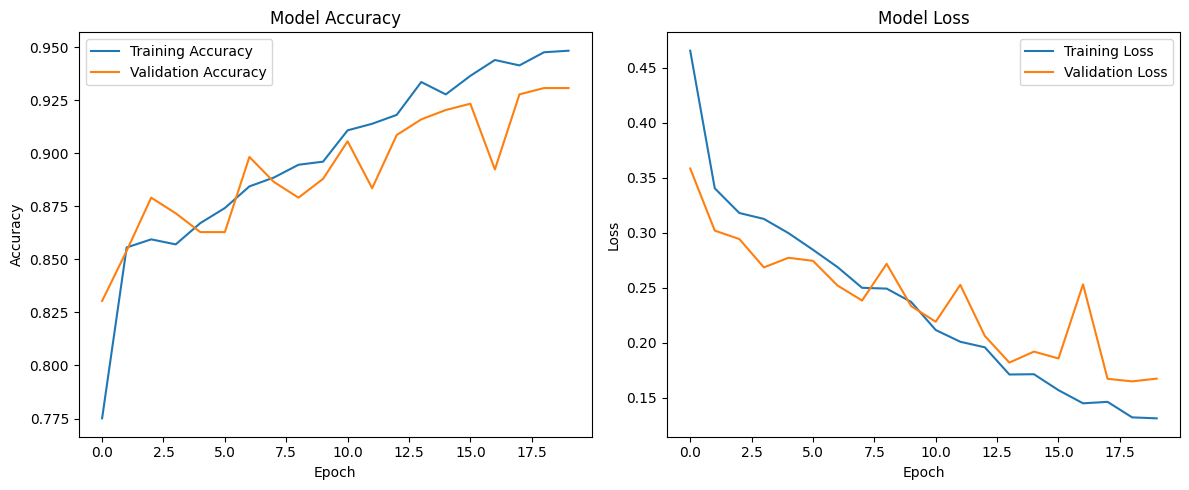

Model saved as 'fingerprint_matching_model.h5'


In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# # Check for GPU availability
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# if len(tf.config.experimental.list_physical_devices('GPU')) == 0:
#     raise RuntimeError("This code requires a CUDA-enabled GPU to run")

# # Force TensorFlow to use GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Function to load and preprocess fingerprint images
def load_fingerprint_data(data_path, image_size=(90, 90)):
    fingerprints = []
    fingerprint_ids = []
    labels = []
    
    person_folders = os.listdir(data_path)
    
    # Create pairs of fingerprints
    for i, person1 in enumerate(person_folders):
        if not os.path.isdir(os.path.join(data_path, person1)):
            continue
            
        person1_path = os.path.join(data_path, person1)
        person1_images = [f for f in os.listdir(person1_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Create matching pairs (same person)
        for j in range(len(person1_images)):
            for k in range(j+1, len(person1_images)):
                img1_path = os.path.join(person1_path, person1_images[j])
                img2_path = os.path.join(person1_path, person1_images[k])
                
                img1 = load_img(img1_path, color_mode='grayscale', target_size=image_size)
                img2 = load_img(img2_path, color_mode='grayscale', target_size=image_size)
                
                img1_array = img_to_array(img1) / 255.0
                img2_array = img_to_array(img2) / 255.0
                
                fingerprints.append((img1_array, img2_array))
                fingerprint_ids.append((person1, person1))
                labels.append(1)  # 1 for match
        
        # Create non-matching pairs (different persons)
        for j, person2 in enumerate(person_folders[i+1:], i+1):
            if not os.path.isdir(os.path.join(data_path, person2)):
                continue
                
            person2_path = os.path.join(data_path, person2)
            person2_images = [f for f in os.listdir(person2_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            # Limit the number of non-matching pairs to balance the dataset
            if len(person1_images) > 0 and len(person2_images) > 0:
                img1_path = os.path.join(person1_path, person1_images[0])
                img2_path = os.path.join(person2_path, person2_images[0])
                
                img1 = load_img(img1_path, color_mode='grayscale', target_size=image_size)
                img2 = load_img(img2_path, color_mode='grayscale', target_size=image_size)
                
                img1_array = img_to_array(img1) / 255.0
                img2_array = img_to_array(img2) / 255.0
                
                fingerprints.append((img1_array, img2_array))
                fingerprint_ids.append((person1, person2))
                labels.append(0)  # 0 for non-match
    
    return fingerprints, fingerprint_ids, labels

# Function to build the Siamese CNN model
def build_siamese_model():
    # Define shared model
    x1 = layers.Input(shape=(90, 90, 1))
    x2 = layers.Input(shape=(90, 90, 1))
    
    # Shared weights model
    inputs = layers.Input(shape=(90, 90, 1))
    feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    feature = layers.MaxPooling2D(pool_size=2)(feature)
    feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
    feature = layers.MaxPooling2D(pool_size=2)(feature)
    feature_model = Model(inputs=inputs, outputs=feature)
    
    # Apply the feature model to both inputs
    x1_net = feature_model(x1)
    x2_net = feature_model(x2)
    
    # Subtract features
    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
    net = layers.MaxPooling2D(pool_size=2)(net)
    net = layers.Flatten()(net)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(1, activation='sigmoid')(net)
    
    model = Model(inputs=[x1, x2], outputs=net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


# Load your pre-prepared data
X_train_left = np.load('X_train_left.npy')  
X_train_right = np.load('X_train_right.npy')
y_train = np.load('y_train.npy')
    
X_val_left = np.load('X_val_left.npy')
X_val_right = np.load('X_val_right.npy')
y_val = np.load('y_val.npy')
    
X_test_left = np.load('X_test_left.npy')
X_test_right = np.load('X_test_right.npy')
    
y_test = np.load('y_test.npy')

X1_train = X_train_left
X2_train = X_train_right
X1_test = X_test_left
X2_test = X_test_right
    
  
    
print(f"Training data: {len(X1_train)} pairs")
print(f"Testing data: {len(X1_test)} pairs")
    
# Build and compile the model
print("Building and compiling the model...")
model = build_siamese_model()
model.summary()
    
# Train the model
print("Training the model...")
history = model.fit(
    [X1_train, X2_train], 
    y_train,
    validation_data=([X1_test, X2_test], y_test),
    epochs=20,
    batch_size=32
)
    
# Evaluate the model
print("Evaluating the model...")
scores = model.evaluate([X1_test, X2_test], y_test, verbose=1)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")
    
# Predict on test data
y_pred = model.predict([X1_test, X2_test])
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
  
# Calculate confusion matrix and metrics
cm = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(cm)
    
# Calculate True Positives, False Positives, etc.
true_positives = cm[1, 1]
false_positives = cm[0, 1]
true_negatives = cm[0, 0]
false_negatives = cm[1, 0]
    
print("\nFingerprint Matching Results:")
print(f"Correctly identified matches: {true_positives}")
print(f"Incorrectly identified as matches: {false_positives}")
print(f"Correctly identified non-matches: {true_negatives}")
print(f"Incorrectly rejected matches: {false_negatives}")
    
# Calculate precision, recall, and F1-score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)
    
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
    
# Plot training history
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
    
plt.tight_layout()
plt.savefig('fingerprint_training_history.png')
plt.show()
    
# Save the model
model.save('fingerprint_matching_model.h5')
print("Model saved as 'fingerprint_matching_model.h5'")



In [18]:
print("Evaluating the model...")
scores = model.evaluate([X_val_left, X_val_right], y_val, verbose=1)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# Predict on test data
y_pred = model.predict([X_val_left,X_val_right])
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate confusion matrix and metrics
cm = confusion_matrix(y_val, y_pred_binary)
print("\nConfusion Matrix:")
print(cm)

# Calculate True Positives, False Positives, etc.
true_positives = cm[1, 1]
false_positives = cm[0, 1]
true_negatives = cm[0, 0]
false_negatives = cm[1, 0]

print("\nFingerprint Matching Results:")
print(f"Correctly identified matches: {true_positives}")
print(f"Incorrectly identified as matches: {false_positives}")
print(f"Correctly identified non-matches: {true_negatives}")
print(f"Incorrectly rejected matches: {false_negatives}")

Evaluating the model...
20/20 [==============================] - 0s 20ms/step - loss: 0.2054 - accuracy: 0.9133
Test Loss: 0.20539827644824982
Test Accuracy: 0.9132569432258606
20/20 [==============================] - 0s 17ms/step

Confusion Matrix:
[[304  11]
 [ 42 254]]

Fingerprint Matching Results:
Correctly identified matches: 254
Incorrectly identified as matches: 11
Correctly identified non-matches: 304
Incorrectly rejected matches: 42
